<a href="https://colab.research.google.com/github/jsong55/Machine_Learning/blob/master/AF_classification_using__DenseNet_with_trainable_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
import random
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential, layers
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
import datetime
import tensorflow_hub as hub
from google.colab import drive
drive.mount('/content/drive')
!wget https://raw.githubusercontent.com/jsong55/Machine_Learning/master/TF_functions.py
from TF_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, view_random_image

Mounted at /content/drive
--2022-10-24 04:01:39--  https://raw.githubusercontent.com/jsong55/Machine_Learning/master/TF_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10747 (10K) [text/plain]
Saving to: ‘TF_functions.py’

TF_functions.py     100%[===================>]  10.50K  --.-KB/s    in 0s      

2022-10-24 04:01:39 (108 MB/s) - ‘TF_functions.py’ saved [10747/10747]



image shape: (150, 150, 3)


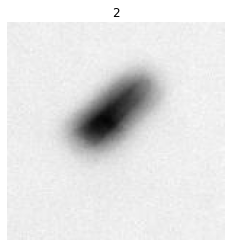

In [2]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/python_torturial/NW_image_quality_50tests_rgb_revserved.zip","r")
zip_ref.extractall()
zip_ref.close()

# Setup the train and test directories
train_dir = "NW_image_quality_50tests_rgb_revserved/train/"
test_dir = "NW_image_quality_50tests_rgb_revserved/test/"

# visualize
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

img = view_random_image(target_dir=train_dir,
              target_class=random.choice(class_names))

In [3]:
IMAGE_SIZE = (150,150)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                        image_size=IMAGE_SIZE,
                                        label_mode="categorical",
                                        batch_size=32,
                                        shuffle=True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                  image_size=IMAGE_SIZE,
                                  label_mode="categorical",
                                  batch_size=32)

Found 2640 files belonging to 5 classes.
Found 1200 files belonging to 5 classes.


In [12]:
base_model = tf.keras.applications.DenseNet121(include_top=False)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_3
1 zero_padding2d_2
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_3
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

In [13]:
# 1. Create base model with tf.keras.applications
# base_model = tf.keras.applications.DenseNet121(include_top=False)
# Check the layers in our base model
#for layer_number, layer in enumerate(base_model.layers):
#  print(layer_number, layer.name)

# The model contains a noramlization and rescaling layer

# 2. Free the base model (the underlying pre-trained patterns aren't updated during training)
base_model.trainable = True

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(150,150,3),name="input_layer")

# 4. If using a model like ResNet50V2, you will need to noramlize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(5,activation="softmax",name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
        optimizer = Adam(),
        metrics=["accuracy"])

# 10. Fit the model and save the history
history_0 = model_0.fit(train_data,
                  epochs=50,
                  steps_per_epoch=len(train_data),
                  validation_data=test_data,
                  validation_steps=int(0.1*len(test_data)),
                  callbacks=[create_tensorboard_callback(dir_name="DenseNet",
                                      experiment_name="DenseNet_test1")])

shape after passing inputs through base model: (None, 4, 4, 1024)
Shape after GlobalAveragePooling2D: (None, 1024)
Saving TensorBoard log files to: DenseNet/DenseNet_test1/20221024-041134
Epoch 1/50
83/83 [==============================] - 42s 247ms/step - loss: 1.1699 - accuracy: 0.5087 - val_loss: 3.5296 - val_accuracy: 0.5104
Epoch 2/50
83/83 [==============================] - 16s 189ms/step - loss: 0.8250 - accuracy: 0.6352 - val_loss: 2.3473 - val_accuracy: 0.3646
Epoch 3/50
83/83 [==============================] - 16s 187ms/step - loss: 0.7263 - accuracy: 0.6621 - val_loss: 1.4333 - val_accuracy: 0.5417
Epoch 4/50
83/83 [==============================] - 16s 190ms/step - loss: 0.6189 - accuracy: 0.7367 - val_loss: 2.5205 - val_accuracy: 0.4479
Epoch 5/50
83/83 [==============================] - 16s 189ms/step - loss: 0.6061 - accuracy: 0.7409 - val_loss: 3.2081 - val_accuracy: 0.3854
Epoch 6/50
83/83 [==============================] - 16s 189ms/step - loss: 0.5483 - accuracy: 0.7

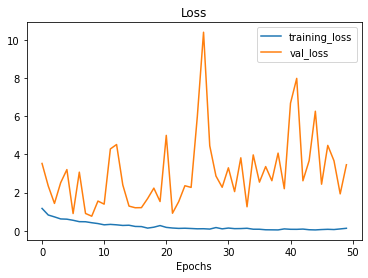

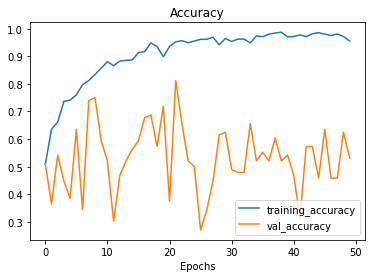

In [14]:
plot_loss_curves(history_0)